In [1]:
import sklearn
import numpy as np
from keras.datasets import cifar10, mnist, imdb
from random import randrange
import time

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

In [27]:
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras import layers, models, optimizers, backend, metrics, callbacks

Для обучения мы будем использовать датасет CIFAR-10, состоящий из 60000 цветных изображений размера 32x32, разбитых на 10 классов, по 6000 изображений на класс. Обучающая выборка состоит из 50000 изображений, а тестовая -- из 10000.

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Визуализируем классы

In [5]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

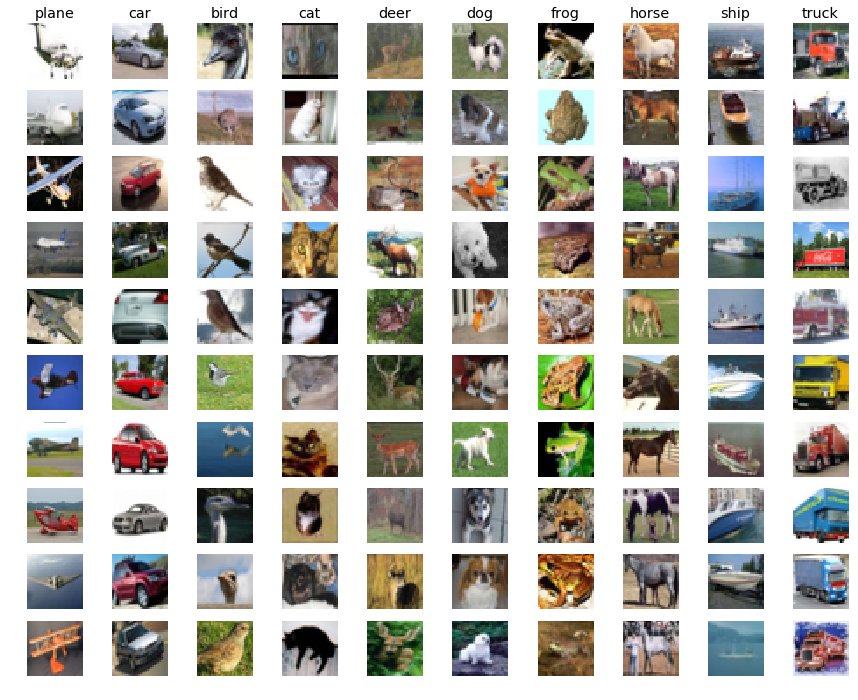

In [6]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Preprocessing: вычитаем среднее

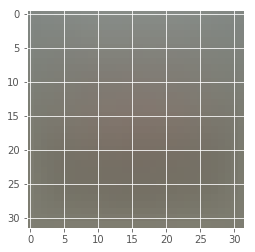

In [7]:
#1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
plt.show()

In [8]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = (x_train - mean_image) / 255
x_test = (x_test - mean_image) / 255

Разделим тренировочную выборку на две части

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1000)

Для решения задачи реализуем топологию [VGG-16](https://arxiv.org/pdf/1409.1556.pdf)

![image.png](http://book.paddlepaddle.org/03.image_classification/image/vgg16.png)

### Опишем граф модели

In [10]:
def build_vgg16():
    # Точка входа в граф задаётся при помощи специальных тензоров типа Input
    image_input = layers.Input(shape=(32,32,3))
    
    x = layers.Conv2D(64, (3, 3), activation='elu', padding='same', name='block1_conv1')(image_input)
    x = layers.Conv2D(64, (3, 3), activation='elu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3), activation='elu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='elu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3), activation='elu', padding='same', name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3), activation='elu', padding='same', name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3), activation='elu', padding='same', name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3), activation='elu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='elu', padding='same', name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='elu', padding='same', name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3), activation='elu', padding='same', name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='elu', padding='same', name='block5_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='elu', padding='same', name='block5_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='elu', name='fc1')(x)
    x = layers.Dense(4096, activation='elu', name='fc2')(x)
    output = layers.Dense(10, activation='softmax', name='predictions')(x)
    
    model = models.Model(inputs=image_input, outputs=output, name = 'vgg16')
    
    
    #  Для оптимизации будем использовать Adam 
    adam = optimizers.Adam(lr=0.0001)
    
    #Перед испльзованием модель необходимо скомпилировать
    model.compile(adam, 'sparse_categorical_crossentropy', metrics=['acc'])
    
    return model 

Написанная выше функция не осуществляет никаких вычислений, единственное её предназначение -- описание графа.

In [11]:
# Перед созданием модели не забываем очищать сессию
backend.clear_session()
model = build_vgg16()

Keras позволяет выводить на экран удобное табличное описание графа модели

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

VGG-16 очень большая модель, созданная для обучения на Imagenet. Наш датасет сильно меньше, следовательно мы можем "отрезать лишнее"

In [21]:
def build_vgg16_slim():
    # Точка входа в граф задаётся при помощи специальных тензоров типа Input
    image_input = layers.Input(shape=(32,32,3))
    
    x = layers.Conv2D(64, (3, 3), activation='elu', padding='same', name='block1_conv1')(image_input)
    x = layers.Conv2D(64, (3, 3), activation='elu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    x = layers.Dropout(0.3)(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3), activation='elu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='elu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    x = layers.Dropout(0.3)(x)
    
    # Block 3
    x = layers.Conv2D(256, (3, 3), activation='elu', padding='same', name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3), activation='elu', padding='same', name='block3_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    x = layers.Dropout(0.3)(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3), activation='elu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='elu', padding='same', name='block4_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    x = layers.Dropout(0.3)(x)
    
    # Block 5
    x = layers.Conv2D(512, (3, 3), activation='elu', padding='same', name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='elu', padding='same', name='block5_conv2')(x)
    x = layers.GlobalMaxPool2D(name='block5_pool')(x)
    x = layers.Dropout(0.3)(x)
    
    output = layers.Dense(10, activation='softmax', name='predictions')(x)
    
    model = models.Model(inputs=image_input, outputs=output, name = 'vgg16')
    
    
    #  Для оптимизации будем использовать Adam 
    adam = optimizers.Adam(lr=0.001)
    
    #Перед испльзованием модель необходимо скомпилировать
    model.compile(adam, 'sparse_categorical_crossentropy', metrics=['acc'])
    
    return model 

In [22]:
# Перед созданием модели не забываем очищать сессию
backend.clear_session()
model = build_vgg16_slim()

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
__________

Нам удалось сократить модель втрое

### Теперь обучим модель. 
Приведённый ниже код будет аналогом тренировочного цикла из примера Tensorflow

In [28]:
cbs = [
    callbacks.ModelCheckpoint('models/{epoch:02d}-{val_loss:.4f}.h5', save_best_only=True),
    callbacks.TensorBoard(log_dir='models'),
    callbacks.ReduceLROnPlateau(factor=0.1, patience=3, verbose=1, min_lr=0.00001, epsilon=0.01)]


model.fit(x=x_train, 
          y=y_train, 
          batch_size=128, 
          epochs=10, 
          callbacks=cbs,
          validation_data=(x_val, y_val))

Train on 49000 samples, validate on 1000 samples
Epoch 1/10
49000/49000 [==============================] - 16s 331us/step - loss: 0.4183 - acc: 0.8529 - val_loss: 0.6900 - val_acc: 0.7730
Epoch 2/10
49000/49000 [==============================] - 16s 336us/step - loss: 0.3788 - acc: 0.8657 - val_loss: 0.6633 - val_acc: 0.7930
Epoch 3/10
49000/49000 [==============================] - 16s 326us/step - loss: 0.3474 - acc: 0.8783 - val_loss: 0.6658 - val_acc: 0.7850
Epoch 4/10
49000/49000 [==============================] - 16s 328us/step - loss: 0.3121 - acc: 0.8881 - val_loss: 0.6846 - val_acc: 0.7990
Epoch 5/10
49000/49000 [==============================] - 16s 330us/step - loss: 0.2770 - acc: 0.9012 - val_loss: 0.6855 - val_acc: 0.8040
Epoch 6/10
48896/49000 [============================>.] - ETA: 0s - loss: 0.2545 - acc: 0.9085
Epoch 00006: reducing learning rate to 1e-05.
49000/49000 [==============================] - 17s 342us/step - loss: 0.2545 - acc: 0.9084 - val_loss: 0.7013 - val

In [29]:
loss, accuracy = model.evaluate(x_test, y_test, batch_size=128)

10000/10000 [==============================] - 1s 134us/step


In [30]:
print(f'accuracy: {accuracy:.2}')

accuracy: 0.82


 Другое дело :) 

State of the art на cifar-10 равен 98%